# Afraid of flight cancellation?
## Analysis of Pre-Covid US flights
## by Kacper Fiszer

## Background
During Covid pandemic everything got crazy, very much including air travel.  
Even before, **flight delays and cancellations were painful**.  
  
Although delays are annoying and can alter your schedule,  
**what's worse than a flight diverted or cancelled altogether?**

## Investigation Overview
- The analysis is focused on **cancelled and diverted flights**.  
Are they more likely in certain conditions?
- We will also briefly look at **high-level flight delay relations**.

## Dataset Overview
- The dataset contains complete US flight data in the years **2005-2007**.  
Over 21 Million records, flight by flight.
- Plots were generated on a sample for visual clarity.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load cancelled and diverted flights data
df = pd.read_csv('./data/flights_cancelled.csv')

# load full cleaned flight data for the purpose of calculating proportions and extracting a sample
df_full = pd.read_csv('./data/flights_clean.csv')

# extract a sample
df_sample = df_full.sample(10000).copy()

In [3]:
# Fix cancelled / diverted df

# Drop unused columns
df.drop(columns=['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'], inplace=True)

# Fix CancellationCode to be ordered categorical
cancel_counts = df['CancellationCode'].value_counts()
cancel_cat = pd.api.types.CategoricalDtype(cancel_counts.index, ordered=True)
df['CancellationCode'] = df['CancellationCode'].astype(cancel_cat)

# Fix float64 to Int64 (allowing for NaN)
df = df.astype({'CRSElapsedTime':'Int64', 'DepDelay':'Int64'})

In [4]:
# Create additional categorical column for distance to ease multivariate exploration
# bins roughly equal quartiles
bins = [0, 300, 600, 1000, 2000, 5000]
names = ['0-300', '300-600', '600-1000', '1000-2000', '2000-5000']

df_sample['DistanceCat'] = pd.cut(df_sample['Distance'], bins=bins, labels=names)

In [5]:
# Set base color
base_color = sb.color_palette()[0]

# Create tiny supporting tables with proportion calculations
# Proportion of cancelled or diverted flights to all flights in a year
prop_byyear = df['Year'].value_counts().sort_index() / df_full['Year'].value_counts().sort_index()
prop_byyear = prop_byyear.reset_index()
prop_byyear.rename(columns={'index':'Year', 'Year':'Proportion'}, inplace=True)

# Proportion of cancelled or diverted flights to all flights in a month
prop_bymonth = df['Month'].value_counts().sort_index() / df_full['Month'].value_counts().sort_index()
prop_bymonth = prop_bymonth.reset_index()
prop_bymonth.rename(columns={'index':'Month', 'Month':'Proportion'}, inplace=True)

# Proportion of cancelled or diverted flights to all flights by day of week
prop_byday = df['DayOfWeek'].value_counts().sort_index() / df_full['DayOfWeek'].value_counts().sort_index()
prop_byday = prop_byday.reset_index()
prop_byday.rename(columns={'index':'DayOfWeek', 'DayOfWeek':'Proportion'}, inplace=True)

# Part I: Delays
## Are they related to any high-level factors?

## Relation between distance and arrival delay
- It would probably make sense to think that the longer the flight is, the longer the typical delay on arrival.
- Except it is not so. Long flights tend to have **very similar lengths of arrival delays** (or landing ahead of schedule) as shorter flights.  
- Could that be because they have more time in the air to catch on in case of departure delay?  
That's a question for another story.

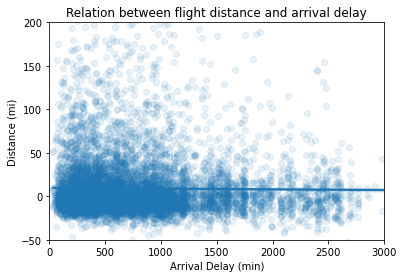

In [6]:
sb.regplot(data=df_sample, x='Distance', y='ArrDelay', scatter_kws={'alpha':0.1})
plt.xlim(0, 3000)
plt.ylim(-50, 200)
plt.xlabel('Arrival Delay (min)')
plt.ylabel('Distance (mi)')
plt.title('Relation between flight distance and arrival delay');

## Relation between departure delay and arrival delay
- If the flight is already **delayed on departure**, it would surely be **delayed upon arrival** as well, right?
- This tends to be **true**, yes - especially **for longer delays**.
- However, with delays in the region of **0 +- 30 minutes** everything can happen.  
That is, **flights ahead of schedule on departure can arrive late or vice versa**.
- **Warning:** contains product placement.

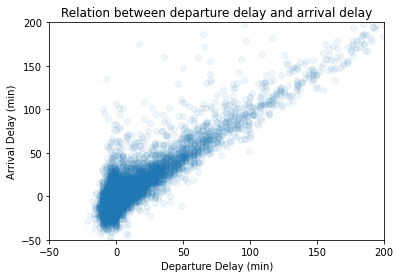

In [7]:
plt.scatter(data=df_sample, x='DepDelay', y='ArrDelay', alpha=0.07)
plt.xlim(-50, 200)
plt.ylim(-50, 200)
plt.xlabel('Departure Delay (min)')
plt.ylabel('Arrival Delay (min)')
plt.title('Relation between departure delay and arrival delay');

## Relation between scheduled flight time and actual elapsed time
- Is it linear? Do flights generally take **as much time as the schedule says**?
- Actually, yes. The industry seems quite reliable, or at least it was before the pandemic.
- The second visual adds distance category to the plot.  
Much of a surprise: **longer distances take more time to fly** .  
But as long as the plot resembles tequila sunrise, I'm fine with that.  

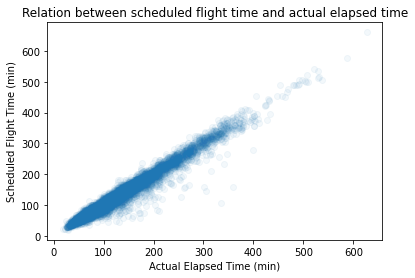

In [8]:
plt.scatter(data=df_sample, x='ActualElapsedTime', y='CRSElapsedTime', alpha=0.05)
plt.xlabel('Actual Elapsed Time (min)')
plt.ylabel('Scheduled Flight Time (min)')
plt.title('Relation between scheduled flight time and actual elapsed time');

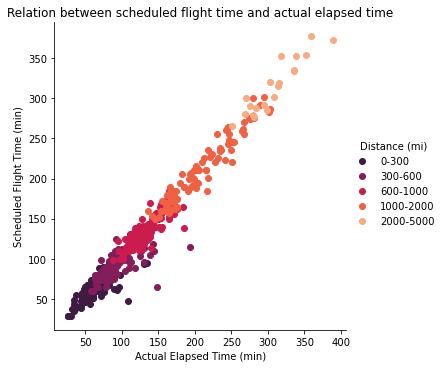

In [9]:
g = sb.FacetGrid(data=df_sample.sample(500), hue='DistanceCat', height=5, palette='rocket')
g.map(plt.scatter, 'ActualElapsedTime', 'CRSElapsedTime')
g.add_legend(title='Distance (mi)')
plt.xlabel('Actual Elapsed Time (min)')
plt.ylabel('Scheduled Flight Time (min)')
plt.title('Relation between scheduled flight time and actual elapsed time');

## Relation between departure delay and arrival delay (cont.)
- As much as the general relation is linear, there is more to it.
- When we break the plot down by distance categories, it appears that for shorter distances the points lie farther apart.
- That is, **for shorter distances the scheduled duration is more likely to differ from the actual duration**.

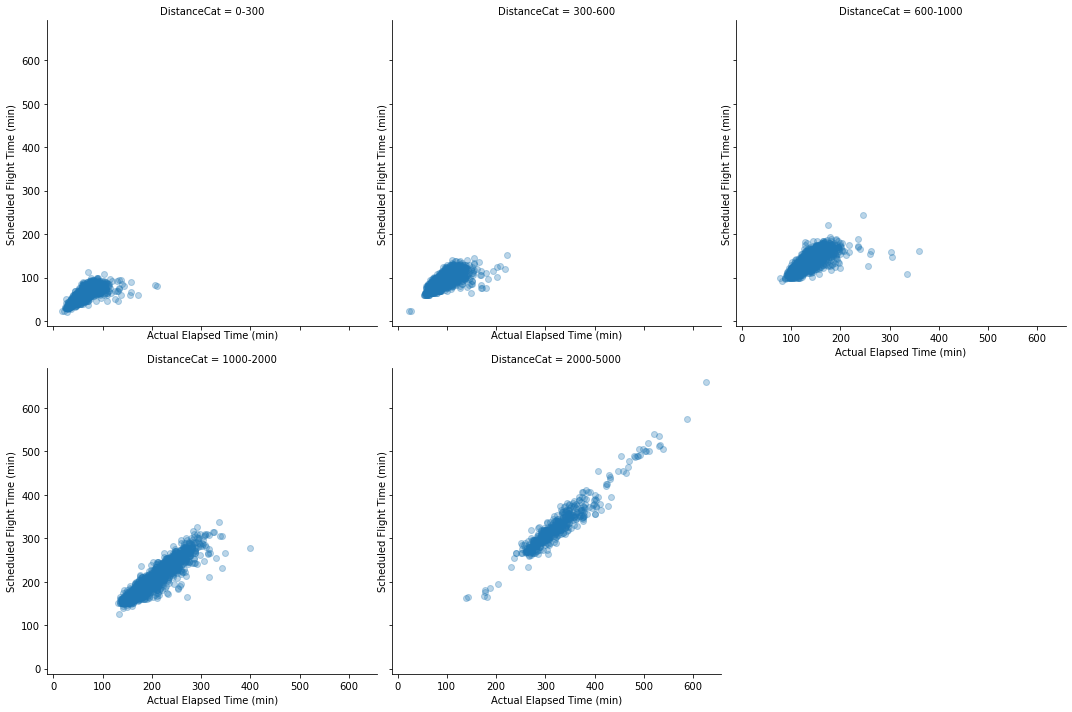

In [10]:
g = sb.FacetGrid(data=df_sample, col='DistanceCat', col_wrap=3, height=5)
g.map(plt.scatter, 'ActualElapsedTime', 'CRSElapsedTime', alpha=0.3)

for l in g.axes :
    l.set_xlabel('Actual Elapsed Time (min)')
    l.set_ylabel('Scheduled Flight Time (min)');

# Part II: Cancelled and Diverted flights
## Should we fear them?
#### (At least when we are back to normal)

## Count and proportion of cancelled or diverted flights by year
- Are there **noticeable fluctuations** year-to-year?
- As you can see in the plot, year **2007 had visibly more cancellations and diverted flights than 2005 or 2006** .
- Still, wouldn't even try to compare that to 2020 or 2021, for the sake of emotional well-being.

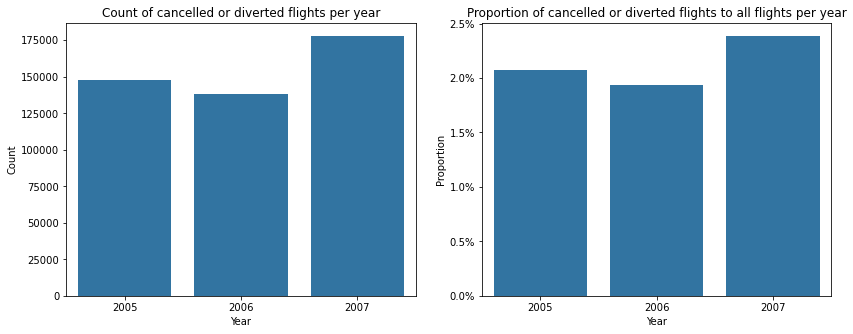

In [11]:
y_ticks = np.arange(0, 0.030, 0.005)
y_labels = [str(l * 100)+'%' for l in y_ticks]

plt.figure(figsize=(12,5))

plt.subplot(121)
sb.countplot(data=df, x='Year', color=base_color)
plt.title('Count of cancelled or diverted flights per year')
plt.ylabel('Count')

plt.subplot(122)
sb.barplot(data=prop_byyear, x='Year', y='Proportion', color=base_color)
plt.yticks(y_ticks, y_labels)
plt.title('Proportion of cancelled or diverted flights to all flights per year')
plt.tight_layout(pad=2);

## Count and proportion of cancelled or diverted flights by month
- Are there **noticeable fluctuations** by each month?
- As you can see, **counts distribution is very similar to proportions**.
- In short, **winter is the season with highest cancelled or diverted flights** numbers.
- **Summer is the second worst** - maybe hot weather is not much better for planes and infrastructure than winter?  
That would require further analysis.

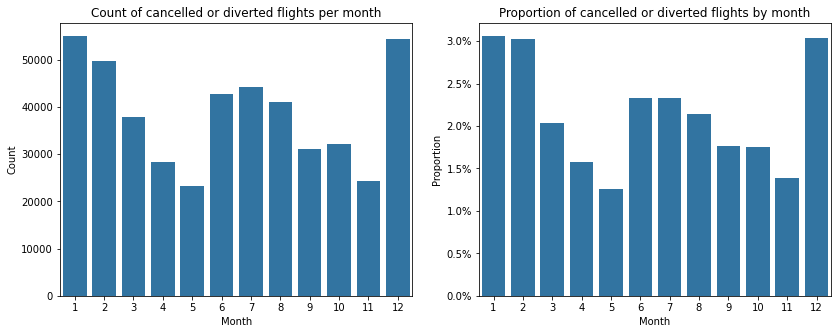

In [12]:
y_ticks = np.arange(0, 0.031, 0.005)
y_labels = [str(l * 100)+'%' for l in y_ticks]

plt.figure(figsize=(12,5))

plt.subplot(121)
sb.countplot(data=df, x='Month', color=base_color)
plt.title('Count of cancelled or diverted flights per month')
plt.ylabel('Count');

plt.subplot(122)
sb.barplot(data=prop_bymonth, x='Month', y='Proportion', color=base_color)
plt.yticks(y_ticks, y_labels)
plt.title('Proportion of cancelled or diverted flights by month')
plt.tight_layout(pad=2);

## Count and proportion of cancelled or diverted flights by day of week
- For the third time proportion behaves mostly similarly to distribution of counts.  
- The proportion of cancelled or diverted flights on weekends is a bit higher than raw counts would suggest.  
- **Weekends and Saturdays in particular were the 'safest' days to avoid a flight being cancelled or diverted**.

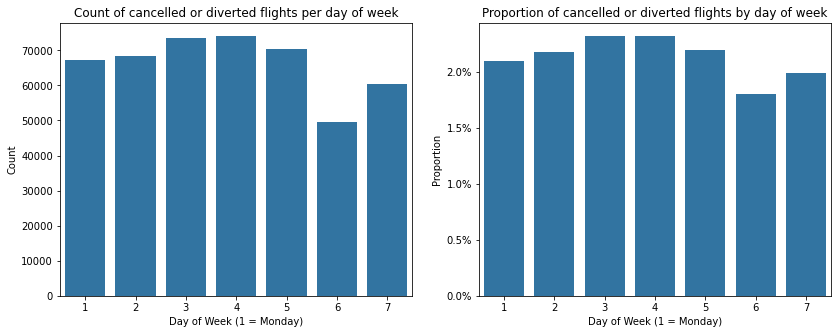

In [13]:
y_ticks = np.arange(0, 0.025, 0.005)
y_labels = [str(l * 100)+'%' for l in y_ticks]

plt.figure(figsize=(12,5))

plt.subplot(121)
sb.countplot(data=df, x='DayOfWeek', color=base_color)
plt.title('Count of cancelled or diverted flights per day of week')
plt.xlabel('Day of Week (1 = Monday)')
plt.ylabel('Count');

plt.subplot(122)
sb.barplot(data=prop_byday, x='DayOfWeek', y='Proportion', color=base_color)
plt.yticks(y_ticks, y_labels)
plt.title('Proportion of cancelled or diverted flights by day of week')
plt.xlabel('Day of Week (1 = Monday)')
plt.tight_layout(pad=2);

## Cancelled or diverted flights by month and day of week
- **Month and day of week seem to have more influence** over cancellations and diverting flights than a year has (sidenote: unless it's 2020 or 2021).
- There is a **higher chance of a flight getting cancelled or diverted on December Fridays**. Christmas peak + bad weather?
- Conversely, the **least cancelled/diverted flights occured on May and November Saturdays**.

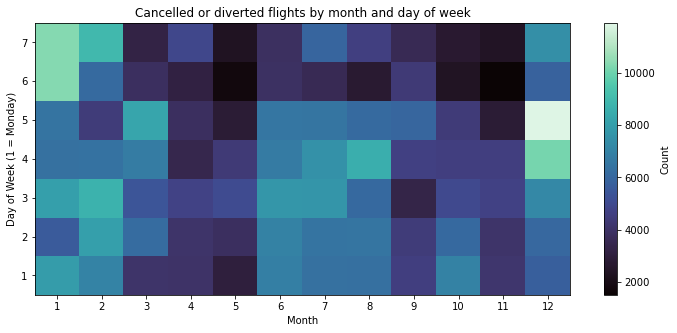

In [14]:
plt.figure(figsize=(12,5))
xbin_edges = np.arange(0.5, 13, 1)
ybin_edges = np.arange(0.5, 8, 1)
x_ticks = np.arange(1, 13)

plt.hist2d(data=df, x='Month', y='DayOfWeek', bins=[xbin_edges, ybin_edges], cmap='mako')
plt.xticks(x_ticks, x_ticks)
plt.colorbar(label='Count')
plt.xlabel('Month')
plt.ylabel('Day of Week (1 = Monday)')
plt.title('Cancelled or diverted flights by month and day of week');

## Count of cancelled or diverted flights by distance
- On a logarithmic scale, the distribution of flight distances appears more normal, with a few peaks.
- Possibly popular big city destinations generating lots of traffic between themselves?
- In any case, **whether or not a flight ends up cancelled or diverted doesn't correlate with flight distance**.

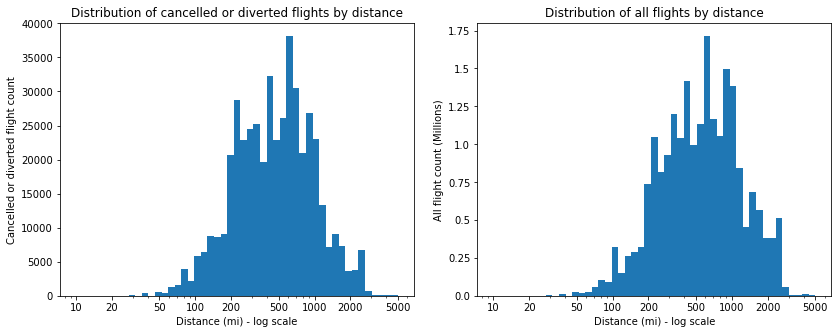

In [15]:
bins = np.logspace(np.log10(10), np.log10(5000), 50)
x_ticks = [10, 20, 50, 100, 200, 500, 1000, 2000, 5000]

y_ticks = np.arange(0, 1760000, 250000)
y_labels = [str(l / int(1e6)) for l in y_ticks]

plt.figure(figsize=(12,5))

plt.subplot(121)
plt.hist(data=df, x='Distance', bins=bins)
plt.xscale('log')
plt.xticks(x_ticks, x_ticks)
plt.xlabel('Distance (mi) - log scale')
plt.ylabel('Cancelled or diverted flight count')
plt.title('Distribution of cancelled or diverted flights by distance');

plt.subplot(122)
plt.hist(data=df_full, x='Distance', bins=bins)
plt.xscale('log')
plt.xticks(x_ticks, x_ticks)
plt.yticks(y_ticks, y_labels)
plt.xlabel('Distance (mi) - log scale')
plt.ylabel('All flight count (Millions)')
plt.title('Distribution of all flights by distance')
plt.tight_layout(pad=2);

## Proportion of flight cancellation reasons
- The **most frequent** reason of flight cancellation are **Carrier issues**.
- **Second** most frequent is the **Weather**.
- Flights are **almost never cancelled due to Security** reasons.

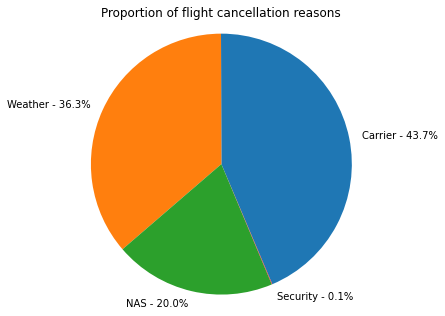

In [16]:
cancel_counts = df['CancellationCode'].value_counts().sort_index().reset_index().rename(columns={'index':'Code', 'CancellationCode':'Count'})
cancel_counts['Prop'] = cancel_counts['Count'] / cancel_counts['Count'].sum()
cancel_counts['Descr'] = ['Carrier', 'Weather', 'NAS', 'Security']
cancel_counts['Label'] = cancel_counts['Descr'] + ' - ' + cancel_counts['Prop'].apply(lambda x: str(round(x, 3)*100)) + '%'

plt.pie(data=cancel_counts, x='Count', labels=cancel_counts['Label'], startangle=-67, radius=1.5)
plt.title('Proportion of flight cancellation reasons', y=1.15);

## Cancellation reasons in relation to flight distance
- For as few as there are (look at the previous pie chart), **Security**-related flight cancellations happen for **shorter flights** than with other reasons.
- **Weather**-related cancellations happen slightly more often for **longer flights** (possibly more uncertainty with destination airport weather?)

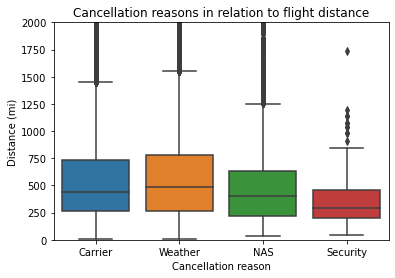

In [17]:
sb.boxplot(data=df, x='CancellationCode', y='Distance', palette='tab10')
plt.xticks(ticks=cancel_counts.index, labels=cancel_counts['Descr'])
plt.ylim(0, 2000)
plt.xlabel('Cancellation reason')
plt.ylabel('Distance (mi)')
plt.title('Cancellation reasons in relation to flight distance');

# Conclusion
- **Delays were only briefly touched upon** and would need to be explored more in-depth.  
Possibly other factors have more influence here: specific carriers, airports, maybe even specific planes or their characteristics?
- Do you really need to worry about cancelled flights?  
In normal times, around **2%** of US flights got **cancelled or diverted**.  
Not much if you ask me or compare it to the risk of being stuck in a traffic jam.
- If you feel like being a bit **more on a safe side**, pick **May or November Saturdays**!

This should work for saving and serving slides:  
`jupyter nbconvert 03_flights_slidedeck.ipynb --to slides --no-input --no-prompt --post serve`